In [1]:
%matplotlib inline

In [2]:
# Make sure we can find ceci

import sys
sys.path.append('/global/homes/a/abrouss/ceci')
sys.path.append('/global/homes/a/abrouss/HyperSuprimeStructure-HSC-LSS')

In [3]:
from glob import glob
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS

In [4]:
pz_bins = [0.15,0.50,0.75,1.00,1.50]
pz_i = pz_bins[:-1]
pz_f = pz_bins[1:]

In [5]:
# A few stolen (and lightly modified) methods from cat_mapper.py and its imports


#from cat_mapper
def get_nmaps(catfolder, pz_code = 'ephor_ab', pz_mark = 'best') :
    """
    Get number counts map from catalog
    """
    maps=[]
    
    if pz_code == 'ephor_ab':
        pz_code_col = 'eab'
    
    cat=fits.open(catfolder + '/clean_catalog.fits')[1].data
    column_mark='pz_'+pz_mark+'_'+pz_code_col

    for zi,zf in zip(pz_i, pz_f) :
        msk_bin=(cat[column_mark]<=zf) & (cat[column_mark]>zi)
        subcat=cat[msk_bin]
        masked_fraction = catfolder + '/masked_fraction.fits'
        fsk,_=read_flat_map(masked_fraction)
        nmap=createCountsMap(subcat['ra'],subcat['dec'],fsk)
        maps.append(nmap)
    return np.array(maps)

# From map_utils
def createCountsMap(ra, dec, flatSkyGrid):
    """
    Creates a map containing the number of objects in each pixel.
    :param ra: right ascension for each object.
    :param dec: declination for each object.
    :param flatSkyGrid: a flatmaps.FlatMapInfo object describing the geometry of the output map.
    """
    flatmap = flatSkyGrid.pos2pix(ra, dec)
    mp = np.bincount(flatmap, weights= None, minlength= flatSkyGrid.get_size())
    return mp


# From flatmaps
def read_flat_map(filename,i_map=0,hdu=None) :
    """
    Reads a flat-sky map and the details of its pixelization scheme.
    The latter are returned as a FlatMapInfo object.
    :param i_map: map to read. If -1, all maps will be read.
    """
    if hdu is None :
        hdul=fits.open(filename)
        w=WCS(hdul[0].header)

        if i_map==-1 :
            maps=np.array([h.data for h in hdul])
            nm,ny,nx=maps.shape
            maps=maps.reshape([nm,ny*nx])
        else :
            maps=hdul[i_map].data
            ny,nx=maps.shape
            maps=maps.flatten()
    else :
        w=WCS(hdu.header)
        maps=hdu.data
        ny,nx=maps.shape
        maps=maps.flatten()

    fmi=FlatMapInfo(w,nx=nx,ny=ny)

    return fmi,maps

# from flatmaps
class FlatMapInfo(object) :
    def __init__(self,wcs,nx=None,ny=None,lx=None,ly=None) :
        """
        Creates a flat map
        :param wcs: WCS object containing information about reference point and resolution
        :param nx,ny: Number of pixels in the x/y axes. If None, dx/dy must be provided
        :param lx,ly: Extent of the map in the x/y axes. If None, nx/ny must be provided
        """
        self.wcs=wcs.copy()

        if nx is None and lx is None :
            raise ValueError("Must provide either nx or lx")

        if ny is None and ly is None :
            raise ValueError("Must provide either ny or ly")

        if nx is None :
            self.lx=lx
            self.nx=int(self.lx/np.abs(self.wcs.wcs.cdelt[0]))+1
        else :
            self.nx=nx
            self.lx=np.fabs(nx*self.wcs.wcs.cdelt[0])
        self.dx=self.lx/self.nx

        if ny is None :
            self.ly=ly
            self.ny=int(self.ly/np.abs(self.wcs.wcs.cdelt[1]))+1
        else :
            self.ny=ny
            self.ly=np.fabs(ny*self.wcs.wcs.cdelt[1])
        self.dy=self.ly/self.ny

        self.npix=self.nx*self.ny
        
    def pos2pix(self,ra,dec) :
        """
        Returns pixel indices for arrays of x and y coordinates.
        Will return -1 if (x,y) lies outside the map
        """
        ra=np.asarray(ra)
        scalar_input=False
        if ra.ndim==0 :
            ra=x[None]
            scalar_input=True

        dec=np.asarray(dec)
        if dec.ndim==0 :
            dec=dec[None]

        if len(ra)!=len(dec) :
            raise ValueError("ra and dec must have the same size!")

        ix,iy=np.transpose(self.wcs.wcs_world2pix(np.transpose(np.array([ra,dec])),0))
        ix=ix.astype(int); iy=iy.astype(int);
        ix_out=np.where(np.logical_or(ix<0,ix>=self.nx))[0]
        iy_out=np.where(np.logical_or(iy<0,iy>=self.ny))[0]

        ipix=ix+self.nx*iy
        ipix[ix_out]=-1
        ipix[iy_out]=-1

        if scalar_input :
            return np.squeeze(ipix)
        return ipix


    def get_size(self) :
        """
        Returns map size
        """
        return self.npix

In [6]:
# ===========================================
#            Actual Code Begins
# ===========================================

catalogs = glob('/global/cscratch1/sd/damonge/HSC_ceci/WIDE_*_sirius_out')

thismap = get_nmaps(catalogs[0])
masked_fraction = catalogs[0] + '/masked_fraction.fits'
fsk,_=read_flat_map(masked_fraction)
geometry = (fsk.nx, fsk.ny)

newmaps = []

print('Reshaping....')

for binmap in thismap:
    newmaps.append(binmap.reshape(geometry))

Reshaping....


Plotting...


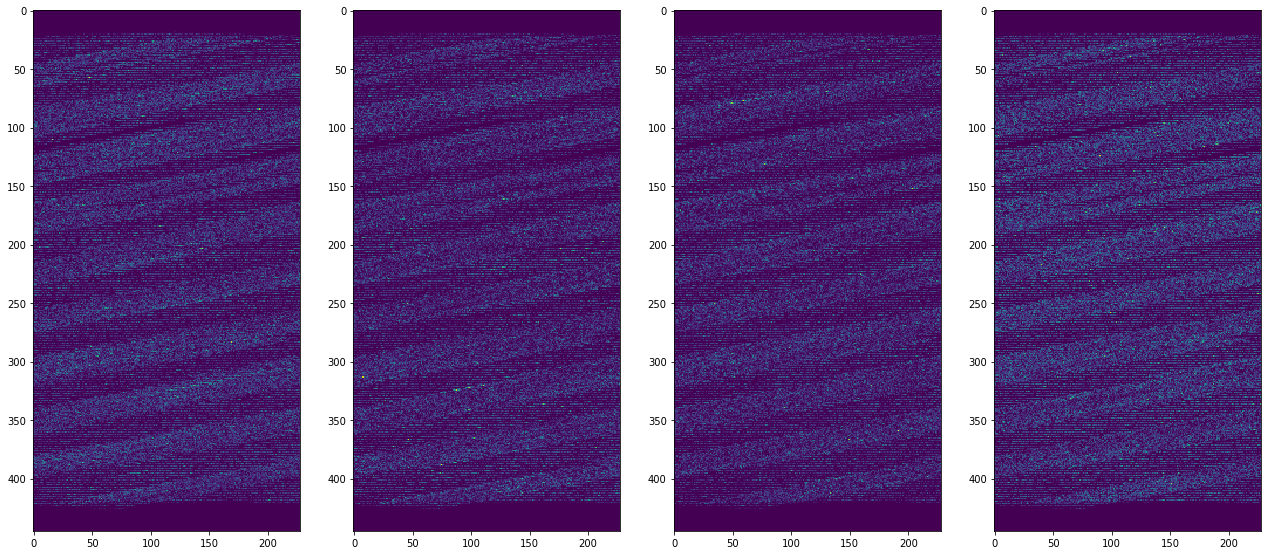

In [13]:
print('Plotting...')

fig, ax = plt.subplots(1,len(newmaps), figsize = (22,44))
for binmap, axis in zip(newmaps, ax):
    axis.imshow(binmap, cmap = 'viridis')
savefig('./nmap.png', bbox_inches = 'tight')

In [10]:
# def get_nmaps(catfolder, pz_code = 'ephor_ab', pz_mark = 'best') :
#     """
#     Get number counts map from catalog
#     """
#     maps=[]
    
#     if pz_code == 'ephor_ab':
#         pz_code_col = 'eab'
    
#     cat=fits.open(catfolder + '/clean_catalog.fits')[1].data
#     column_mark='pz_'+pz_mark+'_'+pz_code_col

#     for zi,zf in zip(pz_i, pz_f) :
#         msk_bin=(cat[column_mark]<=zf) & (cat[column_mark]>zi)
#         subcat=cat[msk_bin]
#         masked_fraction = catfolder + '/masked_fraction.fits'
#         fsk,_=read_flat_map(masked_fraction)
#         nmap=createCountsMap(subcat['ra'],subcat['dec'],fsk)
#         maps.append(nmap)
#     return np.array(maps)

cat=fits.open(catalogs[0]+ '/clean_catalog.fits')[1].data
pz_code_col = 'eab'
pz_mark = 'best'
column_mark='pz_'+pz_mark+'_'+pz_code_col

msk_bin = ((cat[column_mark] <= pz_f[0]) & (cat[column_mark] > pz_i[0]))
subcat = cat[msk_bin]

masked_fraction = catalogs[0] + '/masked_fraction.fits'
fsk,_=read_flat_map(masked_fraction)
nmap=createCountsMap(subcat['ra'],subcat['dec'],fsk)

In [21]:
flatmap = fsk.pos2pix(subcat['ra'], subcat['dec'])
flatmap.shape

(139643,)

In [14]:
catalogs[0]

'/global/cscratch1/sd/damonge/HSC_ceci/WIDE_HECTOMAP_sirius_out'